In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/outliersremoveddata/File5.csv


In [2]:
!pip install darts

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.2/52.2 kB 1.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 163.8/163.8 kB 4.2 MB/s eta 0:00:00a 0:00:01
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 917.3/917.3 kB 22.3 MB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 55.0 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.4/133.4 kB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.0/44.0 kB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 223.5/223.5 kB 10.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 278.2/278.2 kB 13.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.0/54.0 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.8/40.8 kB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.3/62.3 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.3/135.3 kB 7.5 MB/

In [3]:
import pandas as pd
import numpy as np
import shap
import matplotlib.pyplot as plt
import statsmodels
import seaborn as sns

import torch
import torch.nn as nn

import tensorflow as tf
from tensorflow.keras import layers, losses
from tensorflow.keras.models import Model

from darts import concatenate
from darts.models import NBEATSModel, TransformerModel
from darts.dataprocessing.transformers import Scaler
from darts.timeseries import TimeSeries
from darts.metrics import mape, r2_score

from sklearn.preprocessing import MinMaxScaler, StandardScaler, LabelEncoder, OneHotEncoder, PolynomialFeatures
from sklearn.model_selection import train_test_split

from xgboost import XGBRegressor
import warnings

%matplotlib inline

warnings.filterwarnings('ignore')

2024-07-03 19:34:19.201942: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-03 19:34:19.202056: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-03 19:34:19.365565: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [4]:
st = StandardScaler()
le = LabelEncoder()
minmax = MinMaxScaler(feature_range = (-1,1))

In [5]:
df = pd.read_csv('/kaggle/input/outliersremoveddata/File5.csv')

In [6]:
def get_yearly_data(df, year):
    df_year = df[df['Year'] == year]
    df_year.set_index('Date_Time', inplace=True)
    df_year.index = pd.to_datetime(df_year.index)
    df_year.drop('Year', inplace=True, axis=1)
#     df_year['Date'], df_year['Time'] = df_year.index.date, df_year.index.time
    return df_year

In [7]:
hour2022 = get_yearly_data(df, 2022)

In [36]:
hour2022_new = get_yearly_data(df, 2022)

In [8]:
hour2022c = hour2022.copy()

## Preprocessing

In [9]:
# Encoded the station_pair column
hour2022['station_pair_encoded'] = le.fit_transform(hour2022['Station_Pair'])
hour2022.drop(['Station_Pair'], axis = 1, inplace = True)

In [44]:
hour2022_new['station_pair_encoded'] = le.fit_transform(hour2022_new['Station_Pair'])
hour2022_new.drop(['Station_Pair'], axis=1, inplace=True)

In [ ]:
# Resampling and interpolation

hour2022c = hour2022c.resample('H').max().ffill()
hour2022c['Passenger_Count'] = hour2022c['Passenger_Count'].interpolate(method = 'polynomial', order = 2, axis = 0)

In [10]:
# Lagged and exponential features
def scale_data(df, scaler, columns):
    if len(columns) == 1:
        df[column] = scaler.fit_transform(df[column].values.reshape(-1,1))
    for feature in columns:
        df[feature] = scaler.fit_transform(df[column].values.reshape(-1,1))
    return df

def resample(df, type_resample):
    return df.resample(type_resample).max().ffill()

def interpolate(df, column, order):
    if column == 'all':
        return df.internpolate(method = 'polynomial', order = order, axis = 0)
    return df[column].interpolate(method = 'polynomial', order = order, axis = 0)

# Lagged features
def lag_features(df, lag):
    df = df.copy()
    
    df['Passenger_Count_Lagged_By' + str(lag)] = df['Passenger_Count'].shift(lag)
    df['Passenger_Count_Lagged_By' + str(lag)].fillna(-1, inplace=True)
    df.drop('Passenger_Count', axis=1, inplace=True)
    
    return df

# Exponential features
def exponential_features(df, column, alpha):
    df = df.copy()
    df[column] = df[column].ewm(alpha = alpha).mean()
    return df

# Rolling Mean 
def rolling_mean(df, column, window, rolling = True):
    if rolling == True:
        df['rolling_' + column] = df[column].shift(1).rolling(
            window = window,
            min_periods = 18,
            win_type = 'traing'
        ).mean()
    else:
        df[column] = df[column].rolling(
            window = window,
            min_periods = 18,
            win_type = 'triang'
        ).mean()
    return df

def target_encoding(df, column, target):
    mean_target = hour2022.groupby(column)[target].max()
    df['target_encoded_' + column] = df[column].map(mean_target)
    return df

def feature_cross(df, column1, column2):
    df['fc_'+column1+'_'+column2] = df[column1] + df[column2]
#     df.drop([column1, column2], axis=1, inplace=True)
    return df

In [11]:
# hour2022_1 = lag_features(hour2022, 1)
hour2022_1 = rolling_mean(hour2022, 'Passenger_Count', 24, rolling = False)
hour2022_1 = feature_cross(hour2022_1, 'Sid', 'Did')
hour2022_1 = feature_cross(hour2022_1, 'Is_Holiday', 'Holiday_Type')
hour2022_1_resampled = hour2022_1.resample('H').mean()

In [16]:
hour2022_1['Passenger_Count'].fillna(-1, inplace=True)

In [14]:
def univariate_data(df, target):
    df = df[[target]].values

hour2022_values = univariate_data(hour2022_1, 'Passenger_Count')

In [17]:
hour2022_1

,Sid,Did,Month,Is_Holiday,Holiday_Type,OneHourSlot,Weekday,Passenger_Count,station_pair_encoded,fc_Sid_Did,fc_Is_Holiday_Holiday_Type
Date_Time,,,,,,,,,,,
2022-01-01 00:00:00,10.0,8.0,1,0,0,1,5,-1.0,0,18.0,0
2022-01-01 01:00:00,10.0,8.0,1,0,0,2,5,-1.0,0,18.0,0
2022-01-01 02:00:00,10.0,8.0,1,0,0,3,5,-1.0,0,18.0,0
2022-01-01 03:00:00,10.0,8.0,1,0,0,4,5,-1.0,0,18.0,0
2022-01-01 04:00:00,10.0,8.0,1,0,0,5,5,-1.0,0,18.0,0
...,...,...,...,...,...,...,...,...,...,...,...
2022-12-31 19:00:00,12.0,8.0,12,0,0,20,5,0.0,33,20.0,0
2022-12-31 20:00:00,12.0,8.0,12,0,0,21,5,0.0,33,20.0,0
2022-12-31 21:00:00,12.0,8.0,12,0,0,22,5,0.0,33,20.0,0


## Analysis

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_corr(df):
    plt.figure(figsize=(12, 12))  # Increase DPI for better resolution
    
    corr_matrix = df.corr('pearson')
    
    sns.heatmap(corr_matrix, annot=True, fmt='.2f', 
                annot_kws={'size': 10},  # Adjust font size for annotations
                cmap='coolwarm',  # Set a color map 
                square=True
               )
    
    plt.xticks(fontsize=12)  # Adjust font size for x-axis labels
    plt.yticks(fontsize=12)  # Adjust font size for y-axis labels
    plt.tight_layout()
    plt.show()


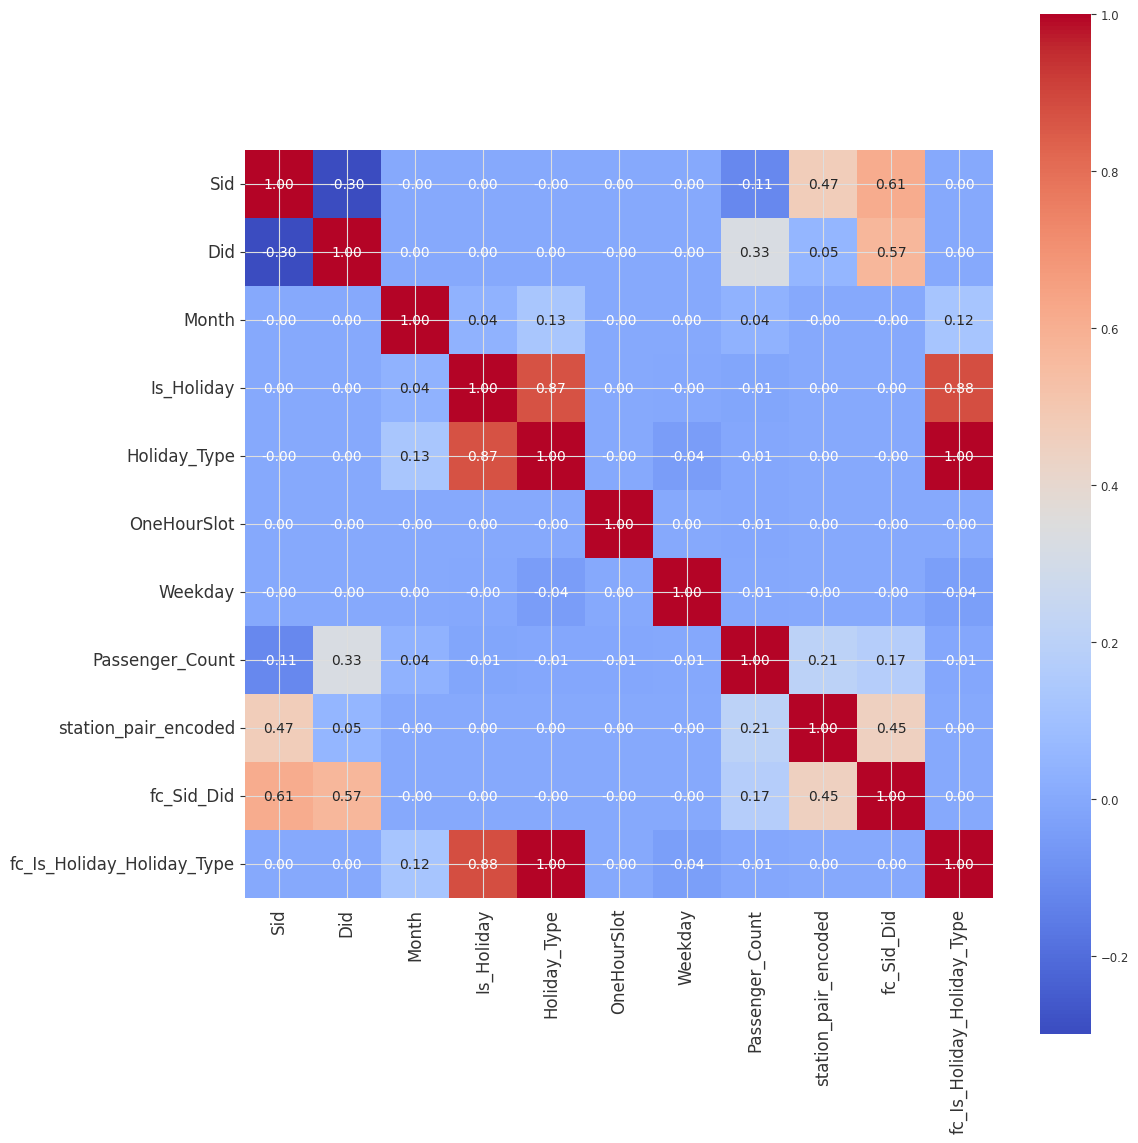

In [66]:
# 2022
plot_corr(hour2022_1)

In [67]:
# using XGBOOST and SHAP
X,y = hour2022_1[['Sid', 'Did', 'fc_Sid_Did', 'Month', 'Is_Holiday', 'Holiday_Type', 'fc_Is_Holiday_Holiday_Type', 'OneHourSlot', 'Weekday', 'station_pair_encoded']], hour2022_1['Passenger_Count']
# X1, y1 = hour2022_1_resampled[['Sid', 'Did', 'fc_Sid_Did', 'Month', 'Is_Holiday', 'Holiday_Type', 'fc_Is_Holiday_Holiday_Type', 'OneHourSlot', 'Weekday', 'station_pair_encoded']], hour2022_1_resampled['Passenger_Count']

In [68]:
import shap
import pandas as pd
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split

class XGBReg:
    def __init__(self, X, y, n_estimators):
        self.X = X
        self.y = y
        self.X_train, self.X_test, self.y_train, self.y_test = self.create_partitions()
        self.fi = None
        self.shap_values = None
        self.is_fit = False
        self.regressor = XGBRegressor(
            n_estimators=n_estimators,
            max_depth=3
        )
    
    def create_partitions(self):
        X_train, X_test, y_train, y_test = train_test_split(self.X, self.y, test_size=0.3, random_state=42)
        return X_train, X_test, y_train, y_test
    
    def fit_model(self):
        self.regressor.fit(
            self.X_train, 
            self.y_train, 
            early_stopping_rounds=20, 
            eval_set=[(self.X_test, self.y_test)]
        )
        self.is_fit = True
    
    def get_feature_importances(self):
        if self.is_fit:
            self.fi = self.regressor.feature_importances_
        else:
            print("Model hasn't been fit yet")
    
    def plot_feature_importances(self):
        if self.fi is None:
            print("Feature importances are not available. Make sure to call `get_feature_importances` first.")
            return
        
        importance_df = pd.DataFrame({'Features': self.X.columns, 'Importances': self.fi})
        importance_df = importance_df.sort_values(by='Importances', ascending=False)
        
        plt.figure(figsize=(10, 8))
        plt.barh(importance_df['Features'], importance_df['Importances'], color='skyblue')
        plt.xlabel('Importance')
        plt.title('Feature Importance')
        plt.gca().invert_yaxis()
        plt.show()
    
    def init_shap(self):
        shap.initjs()
        shap_explainer = shap.Explainer(self.regressor)
        self.shap_values = shap_explaier(self.X_test)
    
    def plot_shap_plots(self, plot_type):
        if plot_type == 'waterfall':
            shap.plots.waterfall(self.shap_values[0])
        if plot_type == 'bee':
            shap.plots.beeswarm(self.shap_values)
        if plot_type == 'None':
            print("Damn, you must not like shap")

[0]	validation_0-rmse:31.65997
[1]	validation_0-rmse:24.53413
[2]	validation_0-rmse:19.61657
[3]	validation_0-rmse:16.60580
[4]	validation_0-rmse:14.63090
[5]	validation_0-rmse:13.56911
[6]	validation_0-rmse:12.80407
[7]	validation_0-rmse:12.31224
[8]	validation_0-rmse:11.93370
[9]	validation_0-rmse:11.49155
[10]	validation_0-rmse:11.21919
[11]	validation_0-rmse:10.92853
[12]	validation_0-rmse:10.66396
[13]	validation_0-rmse:10.49643
[14]	validation_0-rmse:10.34345
[15]	validation_0-rmse:10.20074
[16]	validation_0-rmse:10.08965
[17]	validation_0-rmse:10.01190
[18]	validation_0-rmse:9.86342
[19]	validation_0-rmse:9.51056
[20]	validation_0-rmse:9.45024
[21]	validation_0-rmse:9.32112
[22]	validation_0-rmse:9.24124
[23]	validation_0-rmse:9.12644
[24]	validation_0-rmse:9.09258
[25]	validation_0-rmse:8.99568
[26]	validation_0-rmse:8.92085
[27]	validation_0-rmse:8.89181
[28]	validation_0-rmse:8.78504
[29]	validation_0-rmse:8.76762
[30]	validation_0-rmse:8.73776
[31]	validation_0-rmse:8.72569


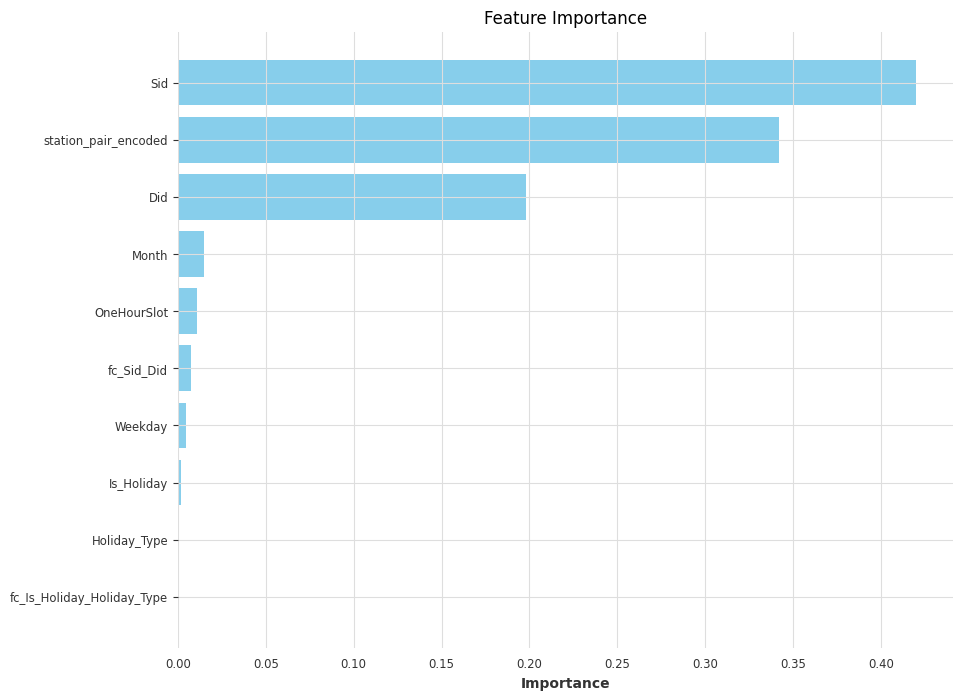

In [69]:
tree = XGBReg(X, y, 150)
tree.fit_model()
tree.get_feature_importances()
tree.plot_feature_importances()

## Models related code

In [17]:
def generate_timesteps_data(timestep: int, train: np.ndarray, test: np.ndarray, return_torch: bool = True):

    if len(train) <= timestep or len(test) <= timestep:
        raise ValueError("The length of train and test datasets must be greater than the timestep.")

    X_train, y_train = [], []
    X_test, y_test = [], []

    for i in range(len(train) - timestep):
        X_train.append(train[i:i + timestep])
        y_train.append(train[i + timestep])

    for i in range(len(test) - timestep):
        X_test.append(test[i:i + timestep])
        y_test.append(test[i + timestep])

    if return_torch:
        return (
            torch.tensor(X_train, dtype=torch.float32),
            torch.tensor(y_train, dtype=torch.float32),
            torch.tensor(X_test, dtype=torch.float32),
            torch.tensor(y_test, dtype=torch.float32)
        )
    else:
        return (
            np.array(X_train),
            np.array(X_test),
            np.array(y_train),
            np.array(y_test)
        )

In [18]:
timestep = 12
train_split = int(len(hour2022_values)*0.8)
train, test = hour2022_values[:train_split], hour2022_values[train_split:]

X_train, y_train, X_test, y_test = generate_timesteps_data(10, train, test, return_torch = True)

In [19]:
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

torch.Size([238262, 10, 1]) torch.Size([238262, 1])
torch.Size([59558, 10, 1]) torch.Size([59558, 1])


In [20]:
# LSTM (torch)dim_order(univariate)
class LSTMmodel(nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2, output_size):
        super(LSTMmodel, self).__init__()
        self.lstm1 = nn.LSTM(input_size, hidden_size1, batch_first=True)
        self.lstm2 = nn.LSTM(hidden_size1, hidden_size2, batch_first=True)
        self.fc = nn.Linear(hidden_size2, output_size)
    
    def forward(self, x):
        h0_1 = torch.zeros(1, x.size(0), self.lstm1.hidden_size)
        c0_1 = torch.zeros(1, x.size(0), self.lstm1.hidden_size)
        
        out, (hn1, cn1) = self.lstm1(x,(h0_1, c0_1))
        
        h0_2 = torch.zeros(1, x.size(0), self.lstm2.hidden_size)
        c0_2 = torch.zeros(1, x.size(0), self.lstm2.hidden_size)
        
        out, (hn2, cn2) = self.lstm2(out, (h0_2, c0_2))
        
        out = self.fc(out[:, -1, :])
        return out

In [21]:
num_epochs = 250
model = LSTMmodel(1, 100, 50, 10)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
for epoch in range(num_epochs):
    model.train()
    outputs = model(X_train)
    optimizer.zero_grad()
    
    loss = criterion(outputs, y_train)
    loss.backward()
    optimizer.step()
    
    if (epoch+1) % 5 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

Epoch [5/250], Loss: 1793.6215
Epoch [10/250], Loss: 1751.0959
Epoch [15/250], Loss: 1708.3052
Epoch [20/250], Loss: 1665.9689
Epoch [25/250], Loss: 1624.9417
Epoch [30/250], Loss: 1585.8507
Epoch [35/250], Loss: 1547.7612
Epoch [40/250], Loss: 1510.8630
Epoch [45/250], Loss: 1474.7535
Epoch [50/250], Loss: 1440.4406
Epoch [55/250], Loss: 1407.2781
Epoch [60/250], Loss: 1375.2135
Epoch [65/250], Loss: 1344.2023
Epoch [70/250], Loss: 1314.2330
Epoch [75/250], Loss: 1285.1582
Epoch [80/250], Loss: 1256.9365
Epoch [85/250], Loss: 1229.4884
Epoch [90/250], Loss: 1202.8707
Epoch [95/250], Loss: 1176.9402
Epoch [100/250], Loss: 1151.7036
Epoch [105/250], Loss: 1127.1189
Epoch [110/250], Loss: 1103.1301
Epoch [115/250], Loss: 1079.8004
Epoch [120/250], Loss: 1056.9897
Epoch [125/250], Loss: 1034.5950
Epoch [130/250], Loss: 1012.7532
Epoch [135/250], Loss: 991.4307
Epoch [140/250], Loss: 970.5239
Epoch [145/250], Loss: 950.0856
Epoch [150/250], Loss: 930.0538
Epoch [155/250], Loss: 910.4686
Ep

In [22]:
# Model testing
model.eval()
with torch.no_grad():
    test = model(X_test)
    test_loss = criterion(test, y_test)
    print(f"Test loss: {test_loss.item()}")

Test loss: 325.9400634765625


In [68]:
# NBEATS (darts)(univariate)
data = hour2022[['Passenger_Count']]
data.interpolate(method='time', order=2, inplace=True, axis=0)
data = data.resample('H').sum().ffill()

Text(0.5, 1.0, 'Something plotted here')

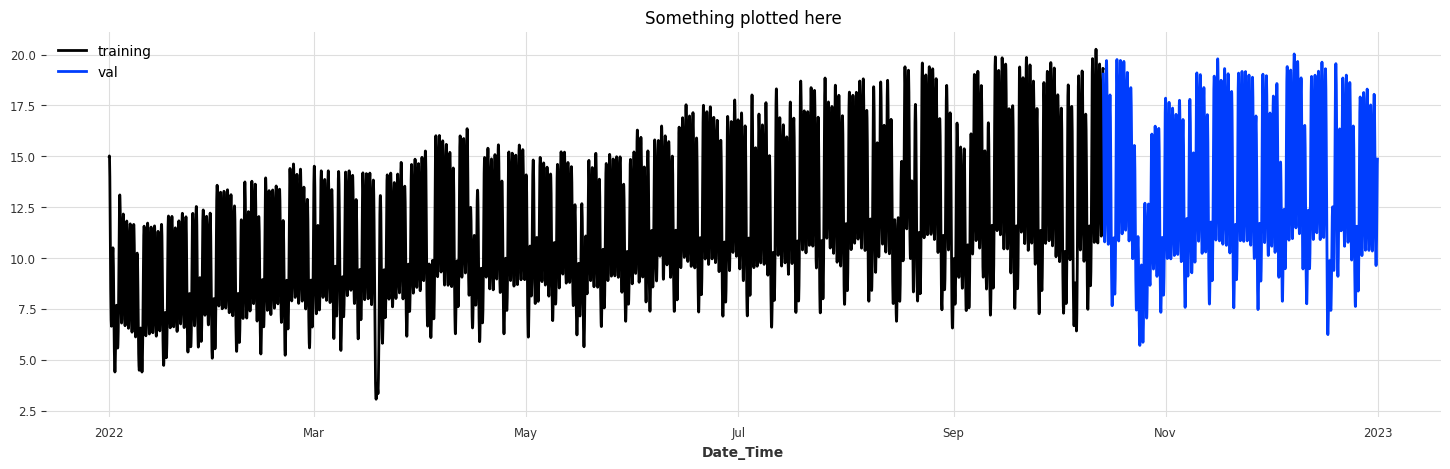

In [69]:
# NBEATS (darts)(univariate)
data = hour2022[['Passenger_Count']]
data.interpolate(method='time', order=2, inplace=True, axis=0)
data = data.resample('H').mean().ffill()

time_series = TimeSeries.from_dataframe(data, fill_missing_dates=True)
train_scaled, val_scaled = time_series.split_after(pd.Timestamp("20221014"))

plt.figure(figsize=(18,5))
train_scaled.plot(label="training")
val_scaled.plot(label="val")
plt.title("Something plotted here")

In [29]:
model_name = "nbeats_run"

NModel = NBEATSModel(
    input_chunk_length = 40, 
    output_chunk_length = 14,
    generic_architecture=True,
    num_stacks = 15,
    n_epochs = 10,
    random_state = 42,
    model_name = model_name,
#     activation = 'LeakyReLU'
)

In [30]:
NModel.fit(train_scaled, val_series=val_scaled)

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

NBEATSModel(output_chunk_shift=0, generic_architecture=True, num_stacks=15, num_blocks=1, num_layers=4, layer_widths=256, expansion_coefficient_dim=5, trend_polynomial_degree=2, dropout=0.0, activation=ReLU, input_chunk_length=40, output_chunk_length=14, n_epochs=10, random_state=42, model_name=nbeats_run)

In [31]:
pred_series = NModel.historical_forecasts(
    time_series,
    start = val_scaled.start_time(),
    forecast_horizon = 12,
    stride = 12,
    last_points_only = False,
    retrain = False,
    verbose = True
)

pred_series = concatenate(pred_series)

def display_forecast(pred_series, ts_transformed, forecast_type, start_date = None):
    plt.figure(figsize=(20,5))
    if start_date:
        ts_transformed = ts_transformed.drop_before(start_date)
    ts_transformed.univariate_component(0).plot(label="actual")
    pred_series.plot(label = ("historic" + forecast_type + "forecasts"))
    plt.title(
        "R2: {}".format(r2_score(ts_transformed.univariate_component(0), pred_series))
    )
    plt.legend()

Predicting: |          | 0/? [00:00<?, ?it/s]

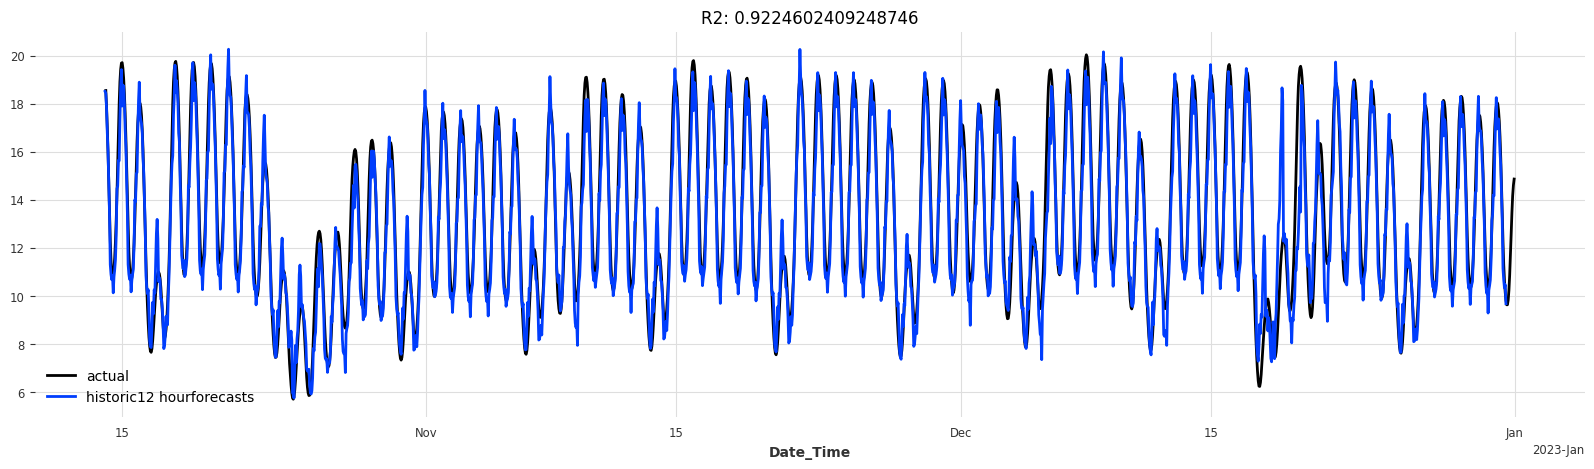

In [33]:
display_forecast(pred_series, time_series, "12 hour", start_date=val_scaled.start_time())

In [45]:
hour2022_new = hour2022_new.groupby('station_pair_encoded')['Passenger_Count'].sum().reset_index()
hour2022_new.sort_values(by=['Passenger_Count'], ascending=False, inplace=True)
hour2022_new['contributions'] = (hour2022_new['Passenger_Count']/hour2022_new['Passenger_Count'].sum())*100

In [46]:
hour2022_new

,station_pair_encoded,Passenger_Count,contributions
26,26,1839545.0,51.999273
28,28,1097906.0,31.035019
4,4,372303.0,10.524062
25,25,99073.0,2.800543
6,6,98671.0,2.789179
32,32,29646.0,0.838017
15,15,221.0,0.006247
10,10,149.0,0.004212
18,18,61.0,0.001724
22,22,22.0,0.000622


Text(0.5, 1.0, 'Something plotted here')

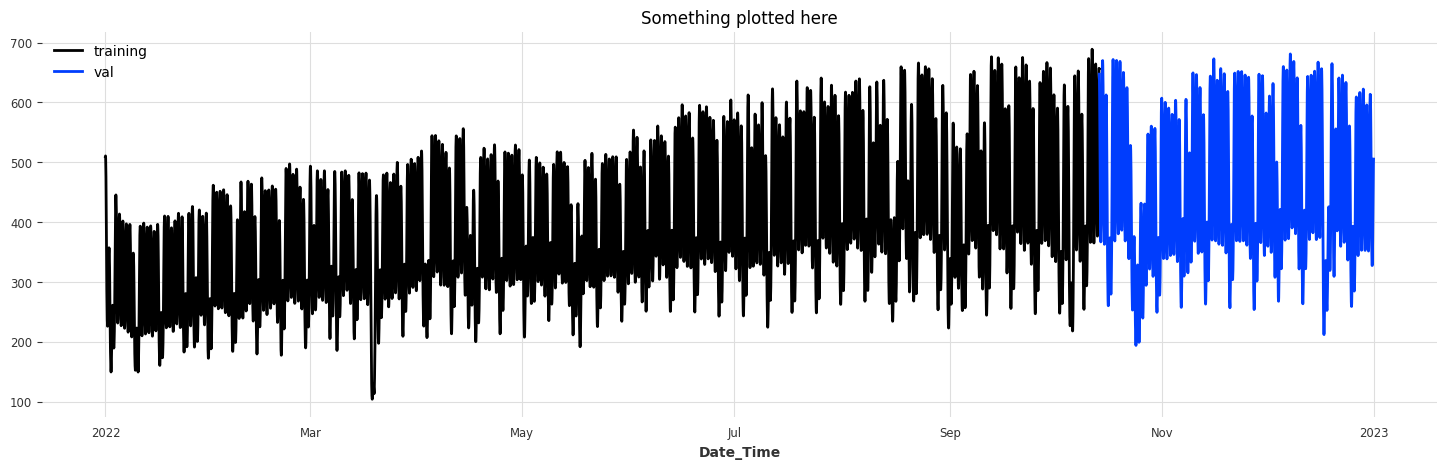

In [49]:
# NBEATS (with top three variables)

data = hour2022[['Passenger_Count', 'station_pair_encoded', 'Sid', 'Did']]
data.interpolate(method='time', order=2, inplace=True, axis=0)
data = data.resample('H').sum().ffill()

time_series = TimeSeries.from_dataframe(data, fill_missing_dates=True)
train_scaled, val_scaled = time_series.split_after(pd.Timestamp("20221014"))

plt.figure(figsize=(18,5))
train_scaled['Passenger_Count'].plot(label="training")
val_scaled['Passenger_Count'].plot(label="val")
plt.title("Something plotted here")

In [52]:
# NBEATS Hybrid (Univariate)

In [70]:
from xgboost import XGBRegressor
from darts.models import ExponentialSmoothing
from darts.utils.utils import ModelMode, SeasonalityMode

model_name = "nbeats_run"

NModel1 = NBEATSModel(
    input_chunk_length = 48, 
    output_chunk_length = 24,
    generic_architecture=True,
    num_stacks = 15,
    n_epochs = 10,
    random_state = 42,
    model_name = model_name,
#     activation = 'LeakyReLU'
)

NModel2 = NBEATSModel(
    input_chunk_length = 24, 
    output_chunk_length = 12,
    generic_architecture=True,
    num_stacks = 15,
    n_epochs = 10,
    random_state = 42,
    model_name = model_name,
#     activation = 'LeakyReLU'
)

exp1 = ExponentialSmoothing(trend = ModelMode.ADDITIVE, seasonal = SeasonalityMode.MULTIPLICATIVE)

exp2 = ExponentialSmoothing(trend = ModelMode.ADDITIVE, seasonal = SeasonalityMode.MULTIPLICATIVE)

Model3 = tf.keras.models.Sequential([
    tf.keras.layers.Dense(10, input_shape = (2,), activation = 'relu'),
    tf.keras.layers.Dense(1)
])


In [71]:
NModel1.fit(train_scaled, val_series = val_scaled, epochs=10)
NModel2.fit(train_scaled, val_series = val_scaled, epochs=10)

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

NBEATSModel(output_chunk_shift=0, generic_architecture=True, num_stacks=15, num_blocks=1, num_layers=4, layer_widths=256, expansion_coefficient_dim=5, trend_polynomial_degree=2, dropout=0.0, activation=ReLU, input_chunk_length=24, output_chunk_length=12, n_epochs=10, random_state=42, model_name=nbeats_run)

In [75]:
def display_forecast(pred_series, ts_transformed, forecast_type, start_date = None):
    plt.figure(figsize=(20,5))
    if start_date:
        ts_transformed = ts_transformed.drop_before(start_date)
    ts_transformed.univariate_component(0).plot(label="actual")
    pred_series.plot(label = ("historic" + forecast_type + "forecasts"))
    plt.title(
        "R2: {}".format(r2_score(ts_transformed.univariate_component(0), pred_series))
    )
    plt.legend()

In [95]:
pred_series1 = NModel1.historical_forecasts(
    time_series,
    start = val_scaled.start_time(),
    forecast_horizon = 1,
    last_points_only = False,
    retrain = False,
    verbose = True
)

pred_series1 = concatenate(pred_series1)

pred_series2 = NModel2.historical_forecasts(
    time_series,
    start = val_scaled.start_time(),
    forecast_horizon = 1,
    last_points_only = False,
    retrain = False,
    verbose = True
)

pred_series2 = concatenate(pred_series2)

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

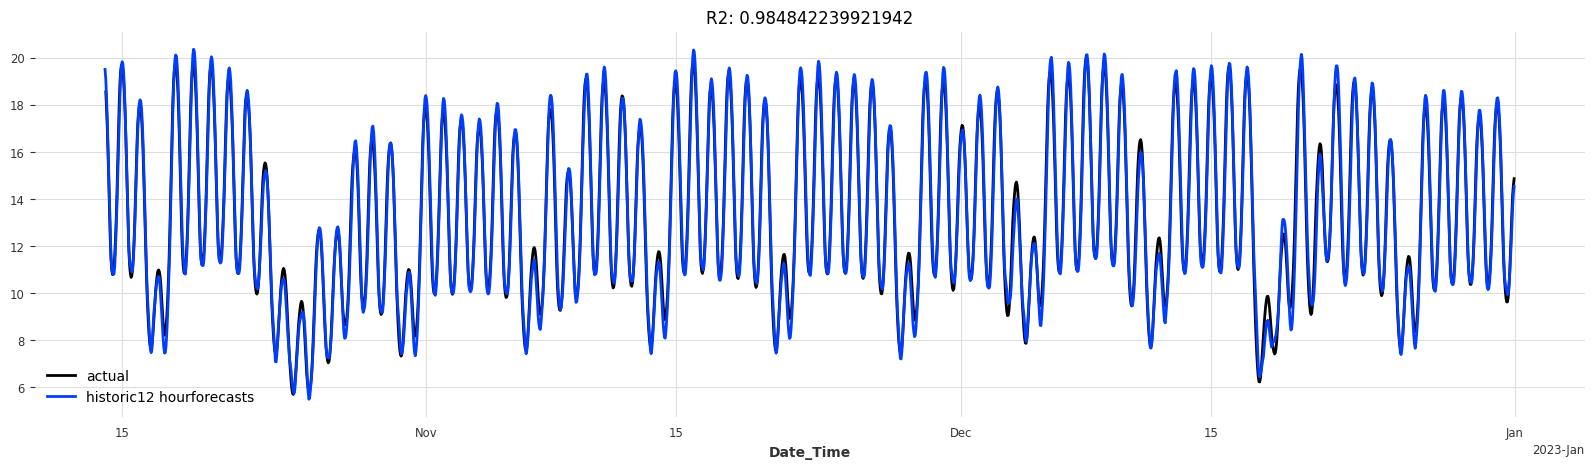

In [96]:
display_forecast(pred_series1, time_series, "12 hour", start_date=val_scaled.start_time())

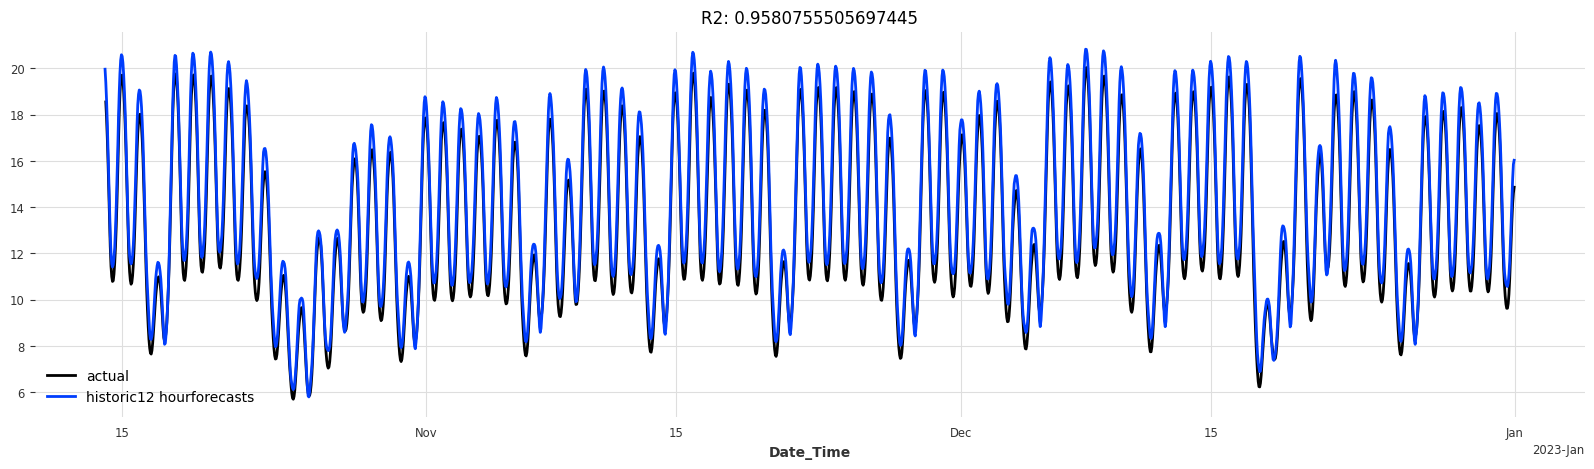

In [97]:
display_forecast(pred_series2, time_series, "12 hour", start_date=val_scaled.start_time())

In [105]:
preds1 = NModel1.predict(12).pd_dataframe()
preds2 = NModel2.predict(12).pd_dataframe()

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

In [106]:
combined_preds = pd.concat([preds1, preds2], axis=1)

In [99]:
val_scaled_df = val_scaled.pd_dataframe()
back_df_1 = pred_series1.pd_dataframe()
back_df_2 = pred_series2.pd_dataframe()

In [100]:
new_data = pd.concat([back_df_1, back_df_2], axis=1)

In [102]:
new_data

component,Passenger_Count,Passenger_Count
Date_Time,,
2022-10-14 01:00:00,19.504449,19.963092
2022-10-14 02:00:00,19.079316,19.401793
2022-10-14 03:00:00,18.319003,18.634368
2022-10-14 04:00:00,17.380509,17.669713
2022-10-14 05:00:00,16.196509,16.468666
...,...,...
2022-12-31 19:00:00,12.071070,13.329486
2022-12-31 20:00:00,12.868113,14.355198
2022-12-31 21:00:00,13.701028,15.233653


In [93]:
val_scaled_df

component,Passenger_Count
Date_Time,
2022-10-14 01:00:00,19.040952
2022-10-14 02:00:00,18.548305
2022-10-14 03:00:00,17.878166
2022-10-14 04:00:00,17.025429
2022-10-14 05:00:00,15.982843
...,...
2022-12-31 19:00:00,12.562704
2022-12-31 20:00:00,13.456393
2022-12-31 21:00:00,14.168096


In [101]:
X_train, X_test, y_train, y_test = train_test_split(new_data ,val_scaled_df, test_size = 0.2)

In [103]:
Model_3 = tf.keras.models.Sequential([
    tf.keras.layers.Dense(10, input_shape=(2,), activation = 'relu'),
    tf.keras.layers.Dense(1)
])

Model_3.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss='mse',
    metrics=['mse']
)

In [104]:
Model_3.fit(X_train, y_train, epochs = 20, validation_data = (X_test, y_test), batch_size = 16)

Epoch 1/20
95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 87.2998 - mse: 87.2998 - val_loss: 7.1417 - val_mse: 7.1417
Epoch 2/20
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.3034 - mse: 3.3034 - val_loss: 0.0798 - val_mse: 0.0798
Epoch 3/20
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0570 - mse: 0.0570 - val_loss: 0.0557 - val_mse: 0.0557
Epoch 4/20
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0511 - mse: 0.0511 - val_loss: 0.0558 - val_mse: 0.0558
Epoch 5/20
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0479 - mse: 0.0479 - val_loss: 0.0556 - val_mse: 0.0556
Epoch 6/20
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0500 - mse: 0.0500 - val_loss: 0.0557 - val_mse: 0.0557
Epoch 7/20
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0450 - mse: 0.0450 - val_loss: 0.0555 - val_mse: 0.0555
Epoch 8/20
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0492 - mse: 0.0492 - val_loss: 0.0557 - val_mse: 0.0557
Epoch 9/20
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0478 - mse

In [108]:
Model_3.predict(X_train)

48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


array([[16.217157],
       [12.84006 ],
       [19.387888],
       ...,
       [19.005892],
       [11.397775],
       [10.620954]], dtype=float32)

In [ ]:
# Transformers (darts)(univariate)
t_data = hour2022[['Passenger_Count']].copy().astype(np.float32)

t_data = t_data.resample('H').mean().ffill()

series = TimeSeries.from_dataframe(t_data, fill_missing_dates=True)

train, val = series.split_after(pd.Timestamp("20221101"))

scaler = Scaler()
train_scaled = scaler.fit_transform(train)
val_scaled = scaler.fit_transform(val)
series_scaled = scaler.fit_transform(series)

In [ ]:
transformer_model = TransformerModel(
    input_chunk_length=12,
    output_chunk_length=1,
    batch_size=32,
    n_epochs=10,
    nhead=8,
    num_encoder_layers=2,
    num_decoder_layers=2,
    dim_feedforward=128,
    dropout=0.1,
    activation="relu",
    random_state=42,
    force_reset=True,
)

In [ ]:
backtest_features = transformer_model.historical_forecasts(
    series = series_scaled,
    start = pd.Timestamp("20221101"),
    forecast_horizon = 6,
    retrain = False,
    verbose = True
)

plt.figure(figsize=(18, 5))
val_scaled.plot(label="actual", lw=2)
backtest_features.plot(label="backtest", lw=2)
plt.legend()
plt.title("Backtest")

In [ ]:
# LSTM (tf)(multivariate) - fail because features suck
timestep = 10
train_split = int(len(hour2022)*0.8)
train, test = hour2022_new[:train_split], hour2022_new[train_split:]

X_train, y_train = [],[]
X_test, y_test = [],[]

for i in range(len(train)-timestep):
    X_train.append(train[i:i+timestep])
    y_train.append(train[i+timestep])

for i in range(len(test)-timestep):
    X_test.append(test[i:i+timestep])
    y_test.append(test[i+timestep])

X_train, y_train = np.array(X_train), np.array(y_train)
X_test, y_test = np.array(X_test), np.array(y_test)

In [ ]:
model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(200, activation='relu', input_shape=(10, 10), return_sequences=True),
    tf.keras.layers.LSTM(100, activation='relu', return_sequences=True),
    tf.keras.layers.LSTM(50, activation='relu', return_sequences=False),
    tf.keras.layers.Dense(10, activation='relu'),
    tf.keras.layers.Dense(1)
])

model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss='mse',
    metrics=['mse']
)